# Packages & Includes

In [3]:
using Plots
using StatsBase
using LinearAlgebra
using Statistics
using JLD2
using Dates
using CurveFit
using StaticArrays

# data structs
include("SpinEnsemble.jl");
include("EchoParams.jl");

# function libraries
include("gen_spins.jl");
include("spin_sims.jl");

# Parameters

In [24]:
# spin variables and operators
Ix = @SMatrix [0 1/2; 1/2 0];
Iy = @SMatrix [0 -1im/2; 1im/2 0];
Iz = @SMatrix [1/2 0; 0 -1/2];
M_op = Ix+1im*Iy;

# magnetic/frequency variables
γ = 2*pi*1e6; # gyromagnetic ratio

# coupling mode variables
α_list = collect(LinRange(0,0.2,9));
ω = 0.001; # 1 kHz

# frequency distribution variables
ν0 = 10; # central frequency, 10 MHz
base_num_freq = 200; # frequency is given by base_num_freq*num_list[i] (looped over i)
num_list = [1,2,3]
bandwidth = 1.0; # bandwidth of dist.

# τ and timing parameters
time_scale = γ;
τ = 100e-6; # time unit
dt = 1; # time spacing
nτ = convert(Int64, round(τ*time_scale/dt)); # probably don't need to round?
t = convert(Array, LinRange(0, 3*τ*1e6, 3*nτ)) # timing list (should probably return from calcs instead)

# for saving the data
nM = 3*nτ;
M_list = zeros(Complex{Float64}, nM, size(α_list,1), size(num_list,1));

# initial density matrix
dim = 2;
ψ_0 = @SArray [1 0];
ρ_temp = [0 0; 0 0];
for i = 1:dim
    for j = 1:dim
        ρ_temp[i,j] = ψ_0[i]*ψ_0[j];
    end
end
ρ_0 = @SMatrix [ρ_temp[1,1] ρ_temp[1,2];
                ρ_temp[2,1] ρ_temp[2,2]];

# pulse operators
UL90 = exp(-1im*pi*Ix/2);
UR90 = exp(1im*pi*Ix/2);

# Simulation loop

In [25]:
integration_samp = true # true: weighted sampling, false: finite sampling
dist_type = 1 # 0: Gaussian/Normal, 1: Lorentzian/Cauchy

if (integration_samp)
    samp_prefix = "integrated"
    samp_inc = 1; # scales the total number of samples
else
    samp_prefix = "discrete"
    samp_inc = 250; # need larger sampling for discrete
end

if (dist_type == 0)
    dist_prefix = "gaussian"
else
    dist_prefix = "lorentzian"
end

α = α_list[1]
params = EchoParams(dt, nτ, ω, α, M_op, Iz, UL90, UR90)


for k = 1:size(num_list,1)
    println(k,"/",size(num_list,1)) # print where we are in sampling list

    num_freq = num_list[k]*base_num_freq*samp_inc;
    ν_list, P_list = gen_spins(ν0, num_freq,integration_samp,dist_type,bandwidth);
    ρ_init = [ρ_0 for j = 1:size(P_list,1)];
    spins = SpinEnsemble(ν0, P_list, ν_list, ρ_init)
    
    # make initial density matrix
    ρ_list = [ρ_0 for j = 1:num_freq];
    
    for i = 1:size(α_list,1)

        params.α = α_list[i];
        # run the evolution
        M = spin_echo_sim(spins,params)
        M_list[:,i,k] = M;
    end
end

1/3
2/3
3/3


# Plotting

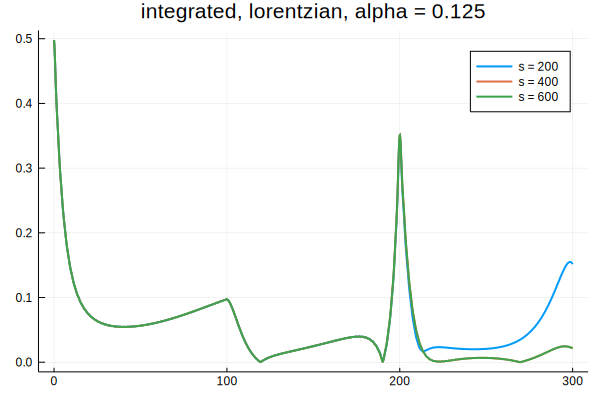

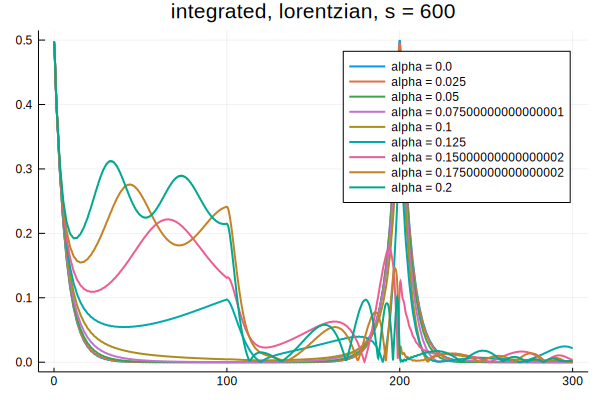

In [27]:
# plot a spin-echo calc
save_figs = false
fname_suffix = ""

plt1 = plot()#plot(xlims=[175,225])
tar_α = 6
for tar_samp = 1:size(num_list,1)
#for tar_α = 1:16
    #tar_samp = 5;
    plot!(t, broadcast(abs,M_list[:,tar_α,tar_samp]),
            title=string(samp_prefix,", ",dist_prefix,", alpha = ",α_list[tar_α]),
            label=string("s = ",num_list[tar_samp]*base_num_freq*samp_inc),
            lw = 2)
end
display(plt1)

fn = string("img/",samp_prefix,"_",dist_prefix,"_sampling_sampling_overlays",fname_suffix,".png")
if save_figs; savefig(plt1,fn); end
plt2 = plot()#plot(xlims=[190, 210])
tar_samp = size(num_list,1);
for tar_α = 1:size(α_list,1)
    plot!(t, broadcast(abs,M_list[:,tar_α,tar_samp]),
            title=string(samp_prefix,", ",dist_prefix,", s = ",num_list[tar_samp]*base_num_freq*samp_inc), 
            label=string("alpha = ",α_list[tar_α]), lw = 2)
end

display(plt2)

fn = string("img/", samp_prefix,"_",dist_prefix,"_sampling_alpha_dependence",fname_suffix,".png")
if save_figs; savefig(plt2,fn); end

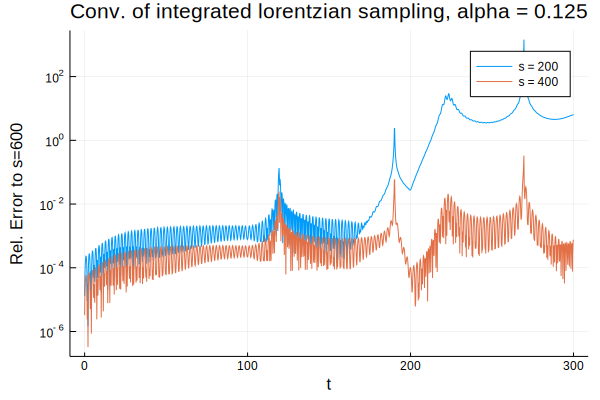

In [28]:
# test convergence in increasing sampling size
save_figs = false
fname_suffix = ""

nS = size(M_list,3);
tar_α = 6;
M_final = M_list[:,tar_α,nS]
plt3 = plot(title=string("Conv. of ", samp_prefix, " ",dist_prefix," sampling, alpha = ",α_list[tar_α]),
    xlabel="t",ylabel=string("Rel. Error to s=",base_num_freq*num_list[nS]*samp_inc) )
for s = 1:(nS-1)
    M_here = M_list[:,tar_α,s]
    plot!(t,broadcast(abs,(M_here-M_final)./M_final),
        yaxis=:log,label=string("s = ",base_num_freq*num_list[s]*samp_inc))
end
display(plt3)

fn = string("img/",samp_prefix,"_",dist_prefix,"_sampling_conv", fname_suffix,".png")
if save_figs; savefig(plt3,fn); end
